In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# Hack pro GPU na Windows
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

### Načteme data

In [3]:
import numpy as np
import os

PATH = os.path.join("datasets", "09", "jena")

In [4]:
import pandas as pd

def load_data(file, path=PATH):
    csv = os.path.join(path, file)
    return pd.read_csv(csv)

In [5]:
data = load_data("jena_climate_2009_2016.csv")

### Prozkoumáme data

In [6]:
data.head(20)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
6,01.01.2009 01:10:00,996.50,-7.62,265.81,-8.30,94.8,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.5
7,01.01.2009 01:20:00,996.50,-7.62,265.81,-8.36,94.4,3.44,3.25,0.19,2.03,3.26,1305.69,0.19,0.50,118.6
8,01.01.2009 01:30:00,996.50,-7.91,265.52,-8.73,93.8,3.36,3.15,0.21,1.97,3.16,1307.17,0.28,0.75,188.5
9,01.01.2009 01:40:00,996.53,-8.43,264.99,-9.34,93.1,3.23,3.00,0.22,1.88,3.02,1309.85,0.59,0.88,185.0


Prozkoumáme, jak se vyvíjela teplota, kterou se také budeme snažit predikovat

<AxesSubplot:>

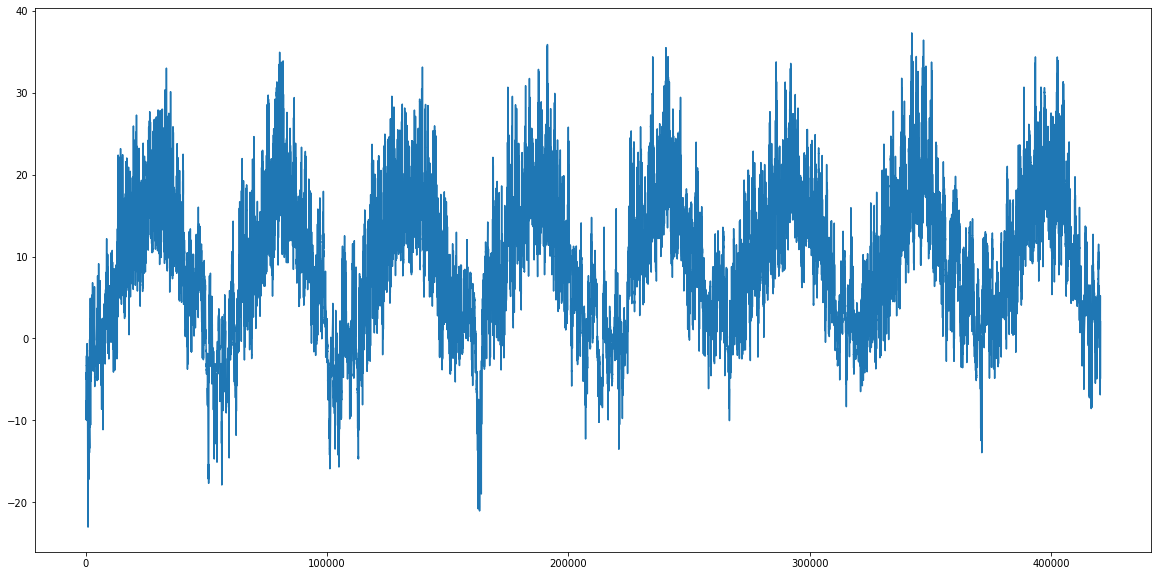

In [7]:
data["T (degC)"].plot(figsize=(20,10))

Zde je dobře vidět roční periodicita vývoje teplot

Podíváme se ještě na záznamy za prvních 10 dnů (6x24x10 = 1440 záznamů)

<AxesSubplot:>

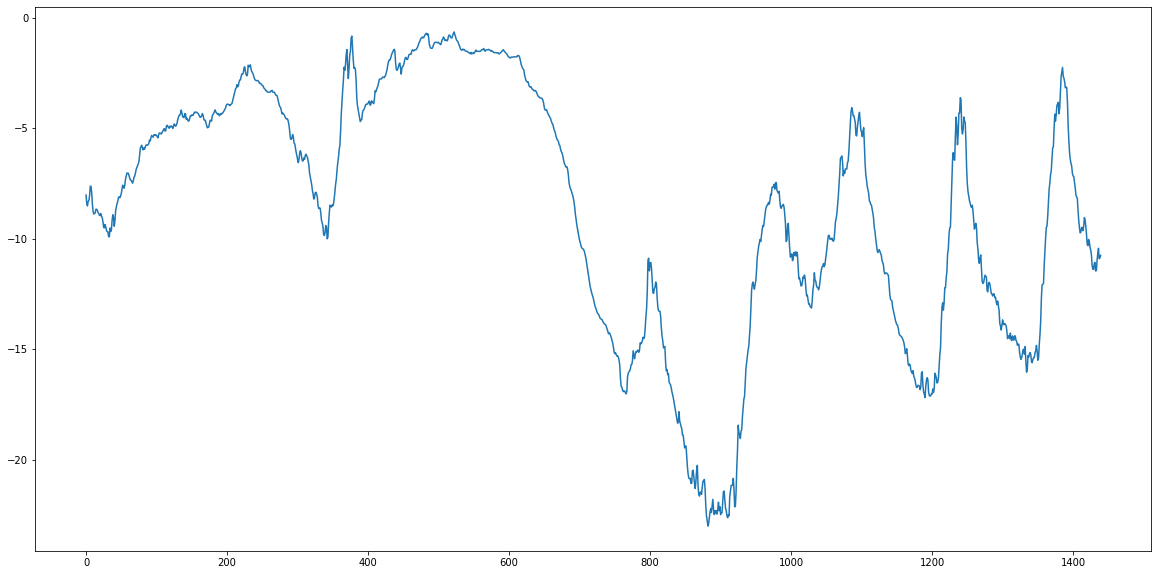

In [8]:
data["T (degC)"][0:1440].plot(figsize=(20,10))

Na posledních 4 dnech v tomto grafu je dobře vidět denní periodicita teplot, ale zároveň je zřejmé, že údaje jsou hodně "rozházené" a predikovat je nebude jednoduché.

### Předpřipravíme data

Potřebujeme si nachystat data tak, aby s nimi šlo pracovat v této regresní úloze.

Konkrétně potřebujeme mít ke zvolenému okamžiku datové body pro X dní zpátky a jako cílovou hodnotu teplotu +24 hodin.

Dále potřebujeme data škálovat, čímž začneme

In [8]:
data.drop(columns=['Date Time'], inplace=True)

In [79]:
np_data = data.to_numpy()

Ukázka, jak ručně a rychle naškálovat číselná data (tj. to, co dělá StandardScaler): odečíst průměr a vydělit směrodatnou odchylkou.

In [80]:
mean = np_data[:200000].mean(axis=0)
np_data -= mean
std = np_data[:200000].std(axis=0)
np_data /= std

Zkontrolujeme jen pro zajímavost:

In [13]:
np_data[:200000].mean(axis=0)

array([ 1.75526793e-14,  1.05728759e-16,  2.24247287e-15, -9.72022463e-17,
        1.13288934e-15,  3.44186901e-16, -2.61479727e-16,  9.36495326e-17,
       -5.11590770e-16, -2.16573426e-16,  1.75077730e-15,  3.16617843e-16,
        1.70530257e-16,  3.71755959e-16])

In [14]:
np_data[:200000].std(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

**Nyní potřebujeme nachystat trénovací data**

Trénovací data chceme mít např. v této podobě: 
- features: údaje za X dní zpátky od zvoleného bodu
- label: údaj za 24 hodin do budoucna od zvoleného bodu

Protože by bylo velmi neúsporné chystat takto postupně všechny posloupnosti dat, nachystáme si na to generátor, který bude trénovací data vytvářet za běhu.  

* `data`
* `lookback`: kolik časových kroků zpátky chceme jít
* `future`: kolik časových kroků do budoucna má být label
* `min_index`, `max_index`: v jaké oblasti dat se chceme pohybovat (důležité, abychom nedostali testovací data do trénovacích)
* `shuffle`: jestli se mají data vybírat náhodně z definované oblasti
* `batch_size`
* `step`: po kolika krocích vybírat data. 6 = 6x10 minut = hodina

In [81]:
def generator(data, lookback, future, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - future - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + future][1]
        yield samples, targets

Nyní si nachystáme generátory trénovacích, validačních a testovacích dat

In [82]:
lookback = 1440 # 10 dní zpátky 
step = 6  # po kolika krocích vybírat časové body
future = 144 # 6 x 24 = 24 hodin dopředu
batch_size = 128 


In [83]:
train_gen = generator(np_data,
                      lookback=lookback,
                      future=future,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)

valid_gen = generator(np_data,
                    lookback=lookback,
                    future=future,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(np_data,
                     lookback=lookback,
                     future=future,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

train_steps = (200000 - lookback) // batch_size
valid_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(np_data) - 300001 - lookback) // batch_size

In [84]:
train_steps, valid_steps, test_steps

(1551, 769, 930)

In [50]:
(X, y) = next(train_gen)

In [51]:
X.shape

(128, 240, 14)

In [52]:
y.shape

(128,)

In [53]:
X[0]

array([[ 0.30230071, -1.21630614, -1.22931041, ...,  0.82581221,
         0.4807585 , -1.76459224],
       [ 0.34593055, -1.25810224, -1.27398697, ...,  1.00802505,
         0.70387003, -1.64682732],
       [ 0.41196491, -1.34960183, -1.37004156, ...,  1.40498873,
         0.8926567 , -1.75524032],
       ...,
       [-2.29898129, -1.49193452, -1.3086113 , ..., -0.17635841,
        -0.36449092,  0.87149465],
       [-2.22705101, -1.48854564, -1.30972821, ...,  0.3117117 ,
         0.29197183,  0.89574037],
       [-2.13979132, -1.4772494 , -1.30637747, ...,  0.23362048,
         0.15467243,  0.9142133 ]])

In [54]:
y[0]

-1.6376560805459657

**Než se pustíme do trénování modelu, měli bychom si dokázat říct, kam se musí výkon modelu dostat, aby měl vůbec smysl**

Např. u binárního klasifikátoru pro MNIST jsme se potřebovali dostat nad 90 %. Někdy může být velmi těžké vytvořit model, který dokáže překonat výkon "selského rozumu". 

V případě predikce teplot bychom patrně mohli uvažovat, že teploty mají standardně jednodenní periodicitu a jsou spojité. Takže selským rozumem bychom mohli říct, že teplota za 24 hodin bude stejná jako teplota nyní. Můžeme zkusit vyhodnotit, jaký by takový "model" měl chybu MAE (průměrná absolutní chyba).

Výpočet MAE na validačních datech podle selského rozumu:

In [56]:
maes = []
for step in range(valid_steps):
    samples, targets = next(valid_gen)
    preds = samples[:, -1, 1]
    mae = np.mean(np.abs(preds - targets))
    maes.append(mae)
    
print(np.mean(maes))

0.28973597299054815


Náš model by měl tedy mít MAE menší než 0.29, aby byl alespoň trochu užitečný. Pokud by nás zajímalo, jak velká chyba to je ve stupních Celsia, musíme MAE vynásobit směrodatnou odchylkou teploty.

In [60]:
mae_c = np.mean(maes) * std[1]
mae_c

2.564887434980494

Průměrná absolutní chyba při aplikaci selského rozumu by tedy byla 2.56°C.

### Začneme jednoduchým, "levným" modelem, než se pustíme do výpočetně náročných RNN

In [121]:
from keras import layers

model = keras.models.Sequential([
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1),
])

In [122]:
model.compile(optimizer='rmsprop', loss='mae')

In [123]:
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [124]:
history = model.fit(train_gen,
                    steps_per_epoch=train_steps,
                    epochs=20,
                    validation_data=valid_gen,
                    validation_steps=valid_steps,
                    callbacks=[early_stopping])

Epoch 1/20
1551/1551 [==============================] - 18s 11ms/step - loss: 1.3407 - val_loss: 0.2999
Epoch 2/20
1551/1551 [==============================] - 18s 11ms/step - loss: 0.2742 - val_loss: 0.3050
Epoch 3/20
1551/1551 [==============================] - 18s 12ms/step - loss: 0.2418 - val_loss: 0.3181
Epoch 4/20
1551/1551 [==============================] - 18s 11ms/step - loss: 0.2243 - val_loss: 0.3790
Epoch 5/20
1551/1551 [==============================] - 17s 11ms/step - loss: 0.2150 - val_loss: 0.3383
Epoch 6/20
1551/1551 [==============================] - 17s 11ms/step - loss: 0.2061 - val_loss: 0.3323


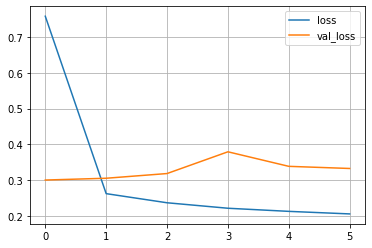

In [125]:
import matplotlib.pyplot as plt
import pandas as pd
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.grid(True)

In [126]:
np.min(history.history['val_loss'])

0.299949586391449

Vidíme, že překonat model "selského rozumu" nebude až tak jednoduché - hustě propojená neuronová síť se dvěma vrstvami na to nestačí. Není to ale tak překvapivé - vrstva Flatten() splácla všechna data vedle sebe, takže ze vstupních dat byl tím pádem odstraněn pojem času. 

### Vyzkoušíme tedy RNN ###

In [115]:
model = keras.models.Sequential([
    layers.GRU(32),
    layers.Dense(1),
])

In [116]:
model.compile(optimizer='rmsprop', loss='mae')

In [117]:
history = model.fit(train_gen,
                    steps_per_epoch=train_steps,
                    epochs=20,
                    validation_data=valid_gen,
                    validation_steps=valid_steps,
                    callbacks=[early_stopping])

Epoch 1/20
1551/1551 [==============================] - 23s 14ms/step - loss: 0.3090 - val_loss: 0.2697
Epoch 2/20
1551/1551 [==============================] - 20s 13ms/step - loss: 0.2705 - val_loss: 0.2739
Epoch 3/20
1551/1551 [==============================] - 20s 13ms/step - loss: 0.2571 - val_loss: 0.2822
Epoch 4/20
1551/1551 [==============================] - 20s 13ms/step - loss: 0.2432 - val_loss: 0.2904
Epoch 5/20
1551/1551 [==============================] - 20s 13ms/step - loss: 0.2307 - val_loss: 0.3010
Epoch 6/20
1551/1551 [==============================] - 21s 14ms/step - loss: 0.2187 - val_loss: 0.3142


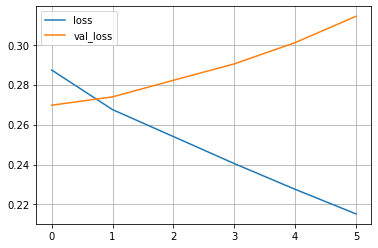

In [119]:
import matplotlib.pyplot as plt
import pandas as pd
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.grid(True)

In [120]:
np.min(history.history['val_loss'])

0.2696911692619324

Vidíme, že s jednoduchým modelem RNN jsme již schopni vcelku výrazně překonat selský rozum.

Zároveň ale vidíme, že model se nám okamžitě od začátku přeučuje. 

**Můžeme si zkusit trochu pohrát s rychlostí učení**

In [129]:
model = keras.models.Sequential([
    layers.GRU(32),
    layers.Dense(1),
])

In [130]:
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.0001), loss='mae')

In [131]:
history = model.fit(train_gen,
                    steps_per_epoch=train_steps,
                    epochs=20,
                    validation_data=valid_gen,
                    validation_steps=valid_steps,
                    callbacks=[early_stopping])

Epoch 1/20
1551/1551 [==============================] - 22s 13ms/step - loss: 0.4279 - val_loss: 0.2782
Epoch 2/20
1551/1551 [==============================] - 20s 13ms/step - loss: 0.2946 - val_loss: 0.2716
Epoch 3/20
1551/1551 [==============================] - 20s 13ms/step - loss: 0.2862 - val_loss: 0.2686
Epoch 4/20
1551/1551 [==============================] - 20s 13ms/step - loss: 0.2840 - val_loss: 0.2676
Epoch 5/20
1551/1551 [==============================] - 20s 13ms/step - loss: 0.2803 - val_loss: 0.2672
Epoch 6/20
1551/1551 [==============================] - 21s 14ms/step - loss: 0.2798 - val_loss: 0.2658
Epoch 7/20
1551/1551 [==============================] - 20s 13ms/step - loss: 0.2759 - val_loss: 0.2664
Epoch 8/20
1551/1551 [==============================] - 20s 13ms/step - loss: 0.2732 - val_loss: 0.2643
Epoch 9/20
1551/1551 [==============================] - 20s 13ms/step - loss: 0.2746 - val_loss: 0.2641
Epoch 10/20
1551/1551 [==============================] - 20s 13m

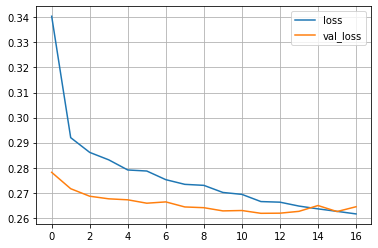

In [132]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.grid(True)

In [134]:
np.min(history.history['val_loss'])

0.26181384921073914

Vidíme, že jsme dokázali chybu opět o něco snížit. 

### Zkusíme využít další techniky proti přeučení ###

Dropout není úplně jednoduché použít v případě rekurentní sítí. Klasická Dropout vrstva zde nefunguje příliš dobře, musíme využít vestavěných vlastností přímo v rekurentní vrstvě. 

Rekurentní vrstvy v Kerasu mají tedy dva nové parametry:
- dropout (platí pro vstupní jednotky vrstvy)
- recurrent_dropout (platí pro rekurentní jednotky vrstvy)


Problém je v tom, že pokud změníme hodnoty recurrent_dropout na nenulové, tak nelze využít podpora GPU a čas potřebný pro zpracování se rapidně prodlouží. 

Výsledek by měl být o něco málo lepší než v minulém případě, ale asi nestojí za to na něj čekat (jedna epocha skoro 50 minut). 

In [141]:
model = keras.models.Sequential([
    layers.GRU(32, dropout=0.2, recurrent_dropout=0,),
    layers.Dense(1),
])

In [142]:
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.0001), loss='mae')

In [143]:
history = model.fit(train_gen,
                    steps_per_epoch=train_steps,
                    epochs=20,
                    validation_data=valid_gen,
                    validation_steps=valid_steps,
                    callbacks=[early_stopping])

Epoch 1/20
1551/1551 [==============================] - 24s 14ms/step - loss: 0.4747 - val_loss: 0.2853
Epoch 2/20
1551/1551 [==============================] - 21s 14ms/step - loss: 0.3129 - val_loss: 0.2781
Epoch 3/20
1551/1551 [==============================] - 22s 14ms/step - loss: 0.3071 - val_loss: 0.2756
Epoch 4/20
1551/1551 [==============================] - 21s 13ms/step - loss: 0.3024 - val_loss: 0.2737
Epoch 5/20
1551/1551 [==============================] - 20s 13ms/step - loss: 0.2978 - val_loss: 0.2722
Epoch 6/20
1551/1551 [==============================] - 20s 13ms/step - loss: 0.2954 - val_loss: 0.2716
Epoch 7/20
1551/1551 [==============================] - 20s 13ms/step - loss: 0.2943 - val_loss: 0.2708
Epoch 8/20
1551/1551 [==============================] - 21s 14ms/step - loss: 0.2932 - val_loss: 0.2705
Epoch 9/20
1551/1551 [==============================] - 21s 14ms/step - loss: 0.2911 - val_loss: 0.2698
Epoch 10/20
1551/1551 [==============================] - 20s 13m

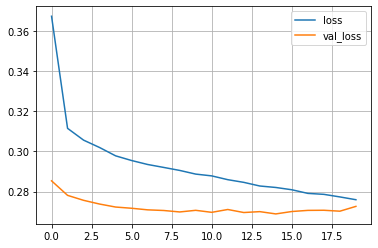

In [147]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.grid(True)

In [148]:
np.min(history.history['val_loss'])

0.2688147723674774

### Zkusíme přidat více vrstev pro zvýšení reprezentačních schopností sítě

In [149]:
model = keras.models.Sequential([
    layers.GRU(32, dropout=0.2, recurrent_dropout=0, return_sequences=True),
    layers.GRU(64, dropout=0.2, recurrent_dropout=0,),
    layers.Dense(1),
])

In [150]:
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.0001), loss='mae')

In [151]:
history = model.fit(train_gen,
                    steps_per_epoch=train_steps,
                    epochs=20,
                    validation_data=valid_gen,
                    validation_steps=valid_steps,
                    callbacks=[early_stopping])

Epoch 1/20
1551/1551 [==============================] - 39s 23ms/step - loss: 0.3739 - val_loss: 0.2857
Epoch 2/20
1551/1551 [==============================] - 37s 24ms/step - loss: 0.3146 - val_loss: 0.2832
Epoch 3/20
1551/1551 [==============================] - 37s 24ms/step - loss: 0.3062 - val_loss: 0.2741
Epoch 4/20
1551/1551 [==============================] - 35s 23ms/step - loss: 0.2996 - val_loss: 0.2727
Epoch 5/20
1551/1551 [==============================] - 36s 23ms/step - loss: 0.2971 - val_loss: 0.2722
Epoch 6/20
1551/1551 [==============================] - 35s 23ms/step - loss: 0.2908 - val_loss: 0.2779
Epoch 7/20
1551/1551 [==============================] - 35s 22ms/step - loss: 0.2873 - val_loss: 0.2766
Epoch 8/20
1551/1551 [==============================] - 35s 23ms/step - loss: 0.2848 - val_loss: 0.2765
Epoch 9/20
1551/1551 [==============================] - 35s 22ms/step - loss: 0.2808 - val_loss: 0.2740
Epoch 10/20
1551/1551 [==============================] - 35s 22m

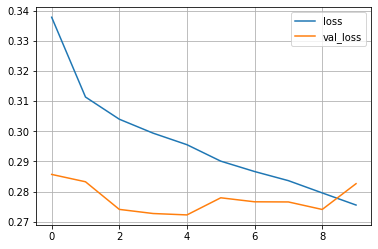

In [152]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.grid(True)

In [153]:
np.min(history.history['val_loss'])

0.2722213566303253